# Why our models have great AUC (around 0.97)

We are going to investigate the over performing models.

## 1). Recover the best model

In [1]:
import pandas as pd
import numpy as np
import torch

from deep_nlp.cnncharclassifier import CNNCharClassifier
from deep_nlp.cnncharclassifier import charToTensor

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import sklearn.metrics as metrics

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# Parameters Kedro
cnn_feature_num= 83
cnn_feature_size= 256
cnn_kernel_one= 7
cnn_kernel_two= 3
cnn_stride_one= 1
cnn_stride_two= 3
cnn_sequence_len= 1014
cnn_output_linear= 1024
cnn_dropout= 0.5
cnn_num_class= 2

cnn_num_threads= 4
cnn_clip= 400
cnn_verbose= False
cnn_freq_verbose= 100
cnn_cuda_allow= True
cnn_patience= 5
cnn_lr= 0.0001
cnn_num_epochs= 50
cnn_size_batch= 86
  # Others
cnn_alphabet= None

In [3]:
# From nodes_cnn_char.py
def cnn_test(test_data, cnn_cuda_allow: bool, cnn_size_batch: int
             , cnn_num_threads: int, model_saved):

    corrects, avg_loss, epoch_loss, size = 0, 0, 0, 0
    predictions_all, target_all, probabilities_all= [], [], []

    test_load = DataLoader(test_data, batch_size=cnn_size_batch
                            , num_workers=cnn_num_threads
                            , drop_last=True, pin_memory=True)

    # Call our model
    model= model_saved
    if cnn_cuda_allow:
        model = torch.nn.DataParallel(model).cuda()
    else:
        model = torch.nn.DataParallel(model)

    # Load our model Char CNN
    # checkpoint= torch.load(model_saved)
    # model.load_state_dict(checkpoint["state_dict"])
    model.eval()

    for batch, data in enumerate(test_load):
        input, target = data
        size += len(target)
        input = input.cuda()
        target = target.cuda()
        input = Variable(input)
        target = Variable(target)

        with torch.no_grad():
            logit = model(input)
            loss = F.nll_loss(logit, target)  # , size_average= False)

            epoch_loss += loss.item()
            predict = torch.max(logit, 1)[1].view(target.size()).data
            corrects += (predict == target.data).sum()

            predictions_all += predict.cpu().numpy().tolist()
            probabilities_all += torch.exp(logit)[:, 1].cpu().numpy().tolist()
            target_all += target.data.cpu().numpy().tolist()

    avg_loss = epoch_loss / len(test_load)  # avg loss (batch level)
    accuracy = 100 * corrects / size  # avg acc per obs

    ## AUC and ROC Curve
    fpr, tpr, threshold = metrics.roc_curve(target_all, probabilities_all)
    auroc = metrics.auc(fpr, tpr)


    log_metric(key="Test_loss", value= avg_loss)
    log_metric(key="Accuracy_test", value= accuracy.cpu().numpy().tolist())
    log_metric(key="AUC_test", value= auroc)

    print("Accuracy : {:.5f} | Avg loss : {:.5f} | AUC : {:.5f}".format(accuracy.cpu().numpy().tolist()
                                                                        , avg_loss, auroc))

    pass

In [4]:
model_path= r"C:\Users\wenceslas\Documents\cours\ENSAE\2A\Normal\statapp\nlp_understanding\data\06_models\cnn_char_classifier\cnn_char_model\cnn_char_model_pytorch.pt"
checkpoint= torch.load(model_path)

In [5]:
# Call our model
kwargs= {"sequence_len": cnn_sequence_len, "feature_num": cnn_feature_num
         , "feature_size": cnn_feature_size, "kernel_one": cnn_kernel_one
         , "kernel_two": cnn_kernel_two, "stride_one": cnn_stride_one
         , "stride_two": cnn_stride_two, "output_linear": cnn_output_linear
         , "num_class": cnn_num_class, "dropout": cnn_dropout}

model= CNNCharClassifier(**kwargs)

In [6]:
# Load our tained model into the new
model= torch.nn.DataParallel(model).cuda()
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

## 2). Load the test dataset

In [7]:
data_csv= pd.read_csv(r"C:\Users\wenceslas\Documents\cours\ENSAE\2A\Normal\statapp\nlp_understanding\data\01_raw\allocine_test.csv")

In [38]:
print(data_csv.head())
print("\n")
print(data_csv.info())
print("\n")
data_csv_copy["num_char"]= data_csv_copy["review"].apply(lambda x: len(x))
print(data_csv_copy.groupby(["label"])["num_char"].mean())
print("\n")
print(data_csv_copy.groupby(["label"])["num_char"].std())
print("\n")
print(data_csv_copy.groupby(["label"])["num_char"].median())

   label                                             review
0      1  Magnifique épopée, une belle histoire, touchan...
1      0  Je n'ai pas aimé mais pourtant je lui mets 2 é...
2      1  Un dessin animé qui brille par sa féerie et se...
3      0  Si c'est là le renouveau du cinéma français, c...
4      0  Et pourtant on s’en Doutait !Second volet très...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20000 non-null  int64 
 1   review  20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
None


label
0    523.925058
1    576.248957
Name: num_char, dtype: float64


label
0    443.508077
1    471.201513
Name: num_char, dtype: float64


label
0    371
1    414
Name: num_char, dtype: int64


## 3). Score the test dataset

In [9]:
corrects, avg_loss, epoch_loss, size = 0, 0, 0, 0
predictions_all, target_all, probabilities_all= [], [], []

test_data= charToTensor(data_csv, cnn_sequence_len)
alphabet= test_data.get_alphabet()+" "

test_load = DataLoader(test_data, batch_size=cnn_size_batch
                        , num_workers=cnn_num_threads
                        , drop_last=True, pin_memory=True)

In [10]:
encoded_text= []

In [11]:
for batch, data in enumerate(test_load):
        x, target = data
        
        for i in x:
            encoded_text.append(i)
            
        size += len(target)
        x = x.cuda()
        target = target.cuda()
        x = Variable(x)
        target = Variable(target)

        with torch.no_grad():
            logit = model(x)
            loss = F.nll_loss(logit, target)  # , size_average= False)

            epoch_loss += loss.item()
            predict = torch.max(logit, 1)[1].view(target.size()).data
            corrects += (predict == target.data).sum()

            predictions_all += predict.cpu().numpy().tolist()
            probabilities_all += torch.exp(logit)[:, 1].cpu().numpy().tolist()
            target_all += target.data.cpu().numpy().tolist()
            

In [12]:
assert len(predictions_all) == len(probabilities_all) == len(encoded_text)

In [13]:
# Get wrong answers
predictions_all_array= np.array(predictions_all)
target_all_array= np.array(target_all)
probabilities_all_array= np.array(probabilities_all)

index_false_answer= predictions_all_array != target_all_array
print(index_false_answer.sum())
print(index_false_answer.sum()/len(predictions_all))

1604
0.08039294306335204


In [14]:
index_wrong= index_false_answer.nonzero()[0]

data_wrong_answer= pd.DataFrame({
    "index":index_wrong,
    "prediction":predictions_all_array[index_wrong],
    "target": target_all_array[index_wrong],
    "proba": probabilities_all_array[index_wrong]
})

In [15]:
get_letter_form_index= np.vectorize(lambda index: alphabet[index])

def rebuild_text(text: torch.Tensor):
    space_index= 83
    
    len_added_zero= np.argmax(np.flip(text.numpy().T.sum(axis= 1)))
    fliped_matrix= np.flip(text.numpy().T[:cnn_sequence_len-len_added_zero], axis= 0)
    
    sentence= np.where(fliped_matrix.sum(axis= 1) == 0, space_index
                       , np.argmax(fliped_matrix, axis= 1))
    
    return "".join(get_letter_form_index(sentence))
        
rebuild_text(encoded_text[789])

"J'en gardais un excellent souvenir : L'image d'une honnete série B de requins, bien réalisée, et très bien jouée (choses rares sur ce type de films). Gla ant de réalisme, les effets spéciaux sont une vrai réussite. A la différence de nombreux films de requins (qui nous ressortent des FX dégueulasses, pas crédibles pour un sou), la bonne idée ici est de peu en montrer. Les prises de vues réelles sont superbes, et très bien intégrées dans l'histoire. D'o  une vrai tension tout au long du film : Le danger est là, mais on ne le voit pas! A noter que Warren (celui qui reste sur le bateau) est le sosie de Franck Dubosc!"

In [16]:
positif_negatif_dict_map= {1: "positif", 0: "negatif"}
data_wrong_answer["label_str"]= data_wrong_answer["target"].map(positif_negatif_dict_map)
data_wrong_answer["review"]= data_wrong_answer["index"].apply(lambda x: rebuild_text(encoded_text[x]))

In [17]:
data_wrong_answer.head()

,index,prediction,target,proba,label_str,review
0,7,0,1,0.258247,positif,"Terrible histoire que ces êtres sans amour, ce..."
1,12,1,0,0.868347,negatif,On ne comprend que guère l'espace et le temps ...
2,17,1,0,0.737710,negatif,Starship Troopers continue sa descente aux enf...
3,23,1,0,0.977344,negatif,"Il y a maintenant presque 50ans, un petit ciné..."
4,39,1,0,0.515484,negatif,"Le duo ne fonctionne pas, le r le sérieux conv..."


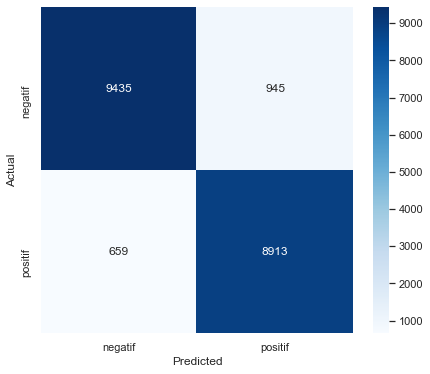

AUC : 0.9760567913640218

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10380
           1       0.90      0.93      0.92      9572

    accuracy                           0.92     19952
   macro avg       0.92      0.92      0.92     19952
weighted avg       0.92      0.92      0.92     19952



In [24]:
# Confusion matrix
data_cm = confusion_matrix(target_all_array, predictions_all_array)

df_cm = pd.DataFrame(data_cm, columns= [positif_negatif_dict_map[i] for i in np.unique(target_all_array)]
                     , index = [positif_negatif_dict_map[i] for i in np.unique(target_all_array)])

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (7,6))

sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g')

plt.show()

# AUC and ROC Curve
fpr, tpr, threshold = metrics.roc_curve(target_all_array, probabilities_all_array)
auroc = metrics.auc(fpr, tpr)

print("AUC : {}\n".format(auroc))

# Classification report
print(metrics.classification_report(target_all_array, predictions_all_array))

In [39]:
data_wrong_answer.to_csv("data_wrong_answer_cnn_char.csv", index= False)

## Read some FP

In [80]:
data_wrong_answer["num_char"]= data_wrong_answer["review"].apply(lambda x: len(x))
print(data_wrong_answer.groupby(["target"])["num_char"].mean())

target
0    551.316402
1    501.801214
Name: num_char, dtype: float64


In [81]:
data_FP= data_wrong_answer[np.logical_and(data_wrong_answer["target"] == 0, data_wrong_answer["prediction"] == 1)].copy()
data_FP= data_FP.reset_index(drop= True)

In [87]:
def print_text(df, num_sample= 10):
    random_index = np.random.randint(low=0, high=df.shape[0], size=(num_sample,))

    for i in random_index:
        print(i)
        print(df["review"][i])
        print("\n")
    pass

print_text(data_FP, 100)

514
Ni fait ni a faire. Ou est le suspens ? Ou est cette ambiance si particulière issue des 2 premiers films ? Paradox est un naufrage au sein de cette excellente saga.


856
1H30 pour une publicité Adidas je trouve que c'est un poil long. J'aurai bien aimé découvrir le film avec ces enfants tout à fait charmants et originaux.Sinon, belle performance de la part de la marque aux 3 bandes pour avoir acheté 1/3 du film.


672
Une étoile à titre documentaire car il s'agit une fois de plus d'un film de propagande à la gloire de l'armée anglaise,de l'église et des bons sentiments.Gene Tierney y apparait toute jeune mais n'y joue aucun r le,elle semble même être rajoutée dans le scénario.Peut importe ,puisque seule sa rayonnante beauté compte,son talent de comédienne ne s'exprimera d'ailleurs plus tard qu'avec certains metteurs en scènes.C'est sans doute le film ou l'on peut le mieux admirer sa splendide chevelure,chacun de ses films mettant particulièrement en lumière une partie d'elle même.

## Read some FN

In [88]:
data_FN= data_wrong_answer[np.logical_and(data_wrong_answer["target"] == 1, data_wrong_answer["prediction"] == 0)].copy()
data_FN= data_FN.reset_index(drop= True)

In [89]:
print_text(data_FN, 100)
del data_FN

502
C'est une histoire vraie. Celle de Philomena Lee qui, tombant enceinte étant adolescente, est envoyée dans un couvent dans lequel elle n'est autorisée à voir son fils une heure par jour avant qu'on le lui enlève, celui ci étant vendu à l'adoption par les bonnes s urs à des américains. Gardant le secret pendant 50 ans, Philomena finit par raconter son histoire à sa fille qui contacte Martin Sixsmith, journaliste récemment licencié afin qu'il l'aide à retrouver son fils et en tire un article. Avec ce film, Stephen Frears se frotte à un sujet sérieux et triste qui aurait vite pu tomber dans le pathos. Heureusement que le scénario (co écrit par Steve Coogan) a l'intelligence d'éviter le larmoyant en gardant toujours une petite note d'humour et en soignant ses personnages. En effet, l'opposition entre Philomena (croyante, na ve, gentille) et Martin (désabusé, se moquant de la religion, cynique) est le vrai moteur du film et leurs oppositions unies dans cette recherche du fils se transfo